# Goal : Unsupervised Object Class Discovery

Object Graph Descriptors, introduced by [1], pool object class feature vectors, derived from methods like Convolutional Neural Networks trained to recognize *known* object classes, in receptive fields which are defined spatially relative to an object candidate. Object classes may be discovered by clustering an affinity matrix of distances between Object Graph Desriptors. The kernel of Object Graph Descriptor distances is known to capture *distinct* information from appearance information (at least, the methods described in [1]).

In [1] the receptive fields are distinguished by distance from the object candidate and by whether the superpixels are above or below the object candidate. This work empirically demonstrates that such a hand-crafted definition works just as well as any similar definition, and that using machine learing methods to *determine* the receptive fields works even better.


* Object Graph Descriptors provide a pretty good context representation for clustering-based approaches to object class discovery.
* Object Graph Descriptors work even better in an iterative setting where discovered classes are used to discover further object classes.
* Can Object Graph Descriptors work even better if receptive fields are learned by some machine learning method? (it turns out yes).
* Can receptive field learning be formulated in a way that adapts to a specific image?

In [1]:
import random
import os
from params import params
import gzip
import pickle
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread
from skimage import img_as_float
from IPython.display import Image
import matplotlib.patches as mpatches
from IPython import display
import numpy as np
import math
import seaborn as sns
sns.set_style('ticks')
import pandas as pd
import splits
%matplotlib inline

# Motivation

The first image shows the distance from a given pixel to the nearest centroid of a labeled object, averaged over all images in MS COCO. Object Graph Descriptors rely on such objects, so the prior distribution of objects in the frame is significant. A non-uniform prior suggests the potential of a non-uniform treatment of receptive fields. 

The second image shows the sum over the COCO validation set of the number of co-occurences of object classes in the same image. The fact that this is non-uniform suggests that context, i.e. using image data (particularly image data related to object classes) *outside* the object candidate, is useful for identifying some object candidate. Note, the heatmap actually uses a log scale because the variance is so high.

The third image shows the average location of an object of class c_i relative to a class c_j for several pairs of classes. This is yet another non-uniformity suggesting the ability of receptive field learning to help computer vision problems like unsupervised object class discovery or object recognition.

Besides these visual forms of motivation, there may be factors unintuitive to people that machine learning algorithms could take advantage of.

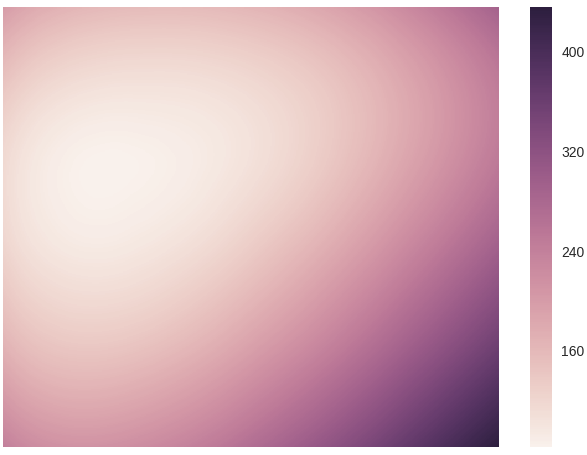

In [7]:
# this information is produced by py2.py:motivation
Image(params.root('results/prior.png'))

0th most common : person, person
1th most common : person, chair
2th most common : chair, chair
3th most common : book, book
4th most common : bottle, bottle
5th most common : car, car
6th most common : person, car
7th most common : bird, bird
8th most common : person, umbrella
9th most common : umbrella, umbrella
10th most common : person, handbag
11th most common : sheep, sheep
12th most common : cup, cup
13th most common : person, cup
14th most common : person, kite
15th most common : person, bottle
16th most common : person, suitcase
17th most common : donut, donut
18th most common : boat, boat
19th most common : potted plant, potted plant
20th most common : bowl, bowl
21th most common : person, backpack
22th most common : person, bench
23th most common : kite, kite
24th most common : person, skis
25th most common : person, skateboard
26th most common : traffic light, traffic light
27th most common : person, dining table
28th most common : suitcase, suitcase
29th most common : car,

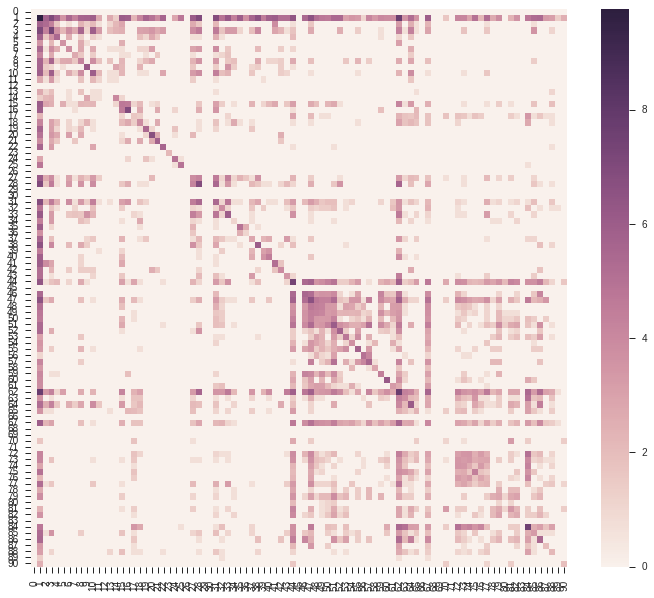

In [6]:
co_occurence, cats, catids = pickle.load(open(params.root('results/co_occurence.pkl'),'rb'),encoding='bytes')
plt.figure(figsize=(12,10))
sns.heatmap(np.log(co_occurence + 1))
plt.savefig('co_occur_map.png')
takenum = 30
for i in range(takenum):
    row, col = np.argmax(co_occurence) // co_occurence.shape[0], np.argmax(co_occurence) % co_occurence.shape[0]
    print("{}th most common : {}, {}".format(i,cats[catids.index(row)]['name'], cats[catids.index(col)]['name']))
    co_occurence[row,col] = 0
    co_occurence[col,row] = 0

In [ ]:
# The center of the 
person_person = imread()
person_cup = imread()
person_bottle = imread()
person_any = imread()
car_trafficlight = imread()
sheep_sheep = imread()

fig, axes = plt.subplots(nrow=3,ncol=2)
axes[0,0].imshow(person_person)
axes[0,0].set_title('Person vs Person')
axes[0,1].imshow(person_cup)
axes[0,1].set_title('Person vs Cup')

# Object Candidates

Here, segmentation algorithms are used to propose object candidates. These experiments use normalized cuts, because a dense segmentation is necessary to have features for all superpixels, but this could in principle be done with more selective techniques like RCNN. Following [2], normalized cuts is run at multiple scales, so that objects of various scales can be candidates for discovery. Following [3], a measure of 'easiness' (depending in part on 'objectness' as discussed later) is used to begin the learning process with easy examples. It is expected that many of the segments, which are possible object candidates, are not object-like and will not be considered due to a low easiness score.

COCO_val2014_000000378453_3.pkl.gz
COCO_val2014_000000461993_2.pkl.gz
COCO_val2014_000000302388_2.pkl.gz


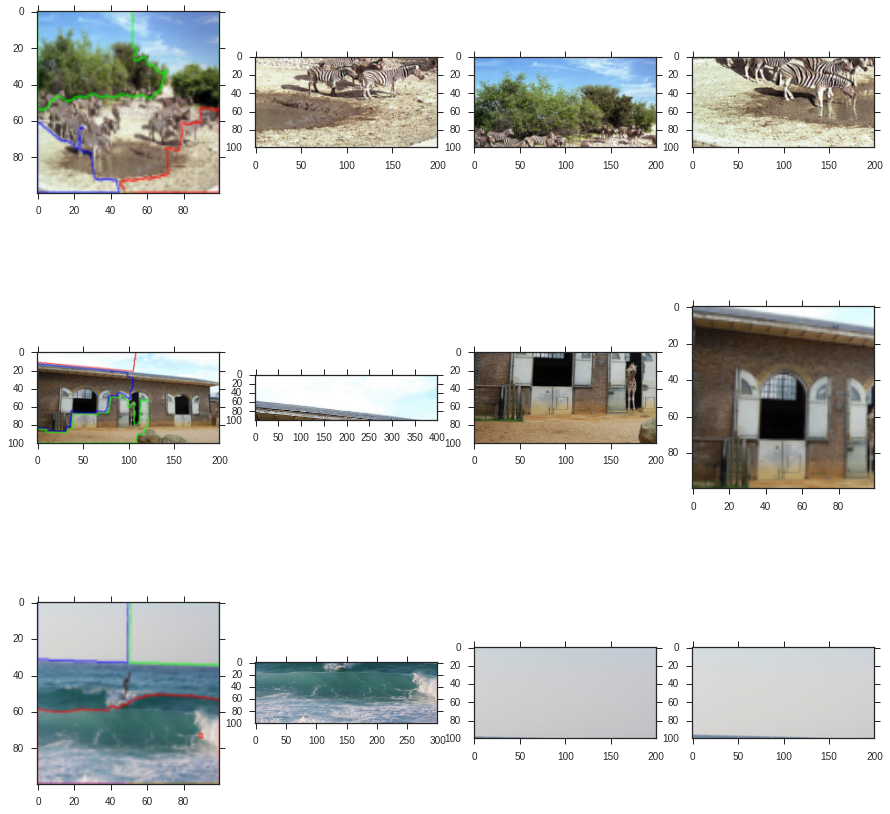

In [113]:
# First column is the full image. 
#Three object candidates are outlined in red, green, and blue. 
#The red object candidate's image data within a bounding box is shown in the second column, 
#the blue is the third column
# and the green is the fourth column.
num_samples = 3
num_segments = 3
colors = [[255,0,0],[0,255,0],[0,0,255]]
display_h = 100
d = params.root('val_segments')
sample = random.sample(os.listdir(d), num_samples)
fig, axes = plt.subplots(nrows=num_samples, ncols=num_segments+1, figsize=(15,15))
for i, segname in enumerate(sample):
    print(segname)
    im = imread(params.root('val_images/{}.jpg'.format('_'.join(segname.split('_')[0:3]))))
    seg = pickle.loads(gzip.open(d + '/' + segname,'rb').read())
    for j in range(0,num_segments):
        img = seg[j].img_patch
        for pix in seg[j].edge_pixels:
            thickline = [(pix[0] - 1, pix[1] - 1), (pix[0], pix[1] - 1), (pix[0] - 1, pix[1]), (pix[0], pix[1]), (pix[0] + 1, pix[1]), (pix[0], pix[1] + 1), (pix[0] + 1, pix[1] + 1)]
            for t in thickline:
                if t[0] < im.shape[0] and t[1] < im.shape[1]: im[t] = colors[j]
        axes[i][j+1].imshow(img_as_float(imresize(img, (display_h, display_h * round(img.shape[1]/img.shape[0])))))
    axes[i][0].imshow(imresize(im, (display_h, display_h * round(im.shape[1] / im.shape[0]))))
plt.savefig('segarr.png')

# Features

[1] used probability distribution over known object classes as the feature. This work also uses probability distributions, but determines them with CNNs.

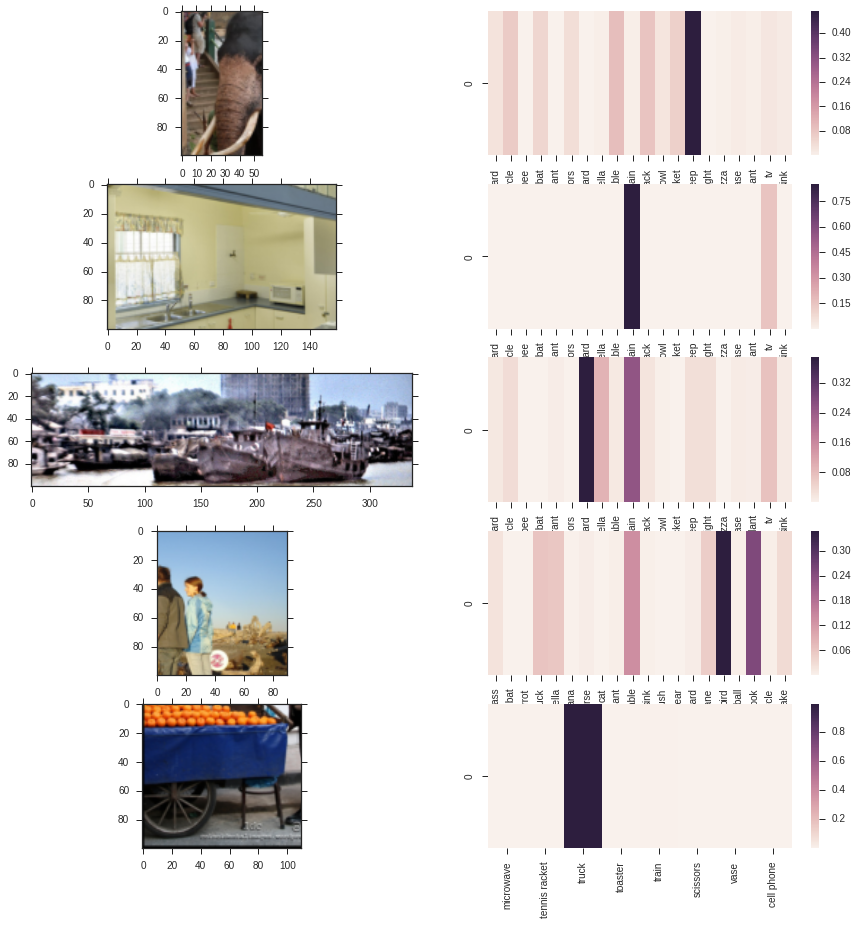

In [116]:
# The features pooled within receptive fields, and the segments they correspond to.
d = params.root('val_segments')
num_samples = 5
num_segments = 1
num_disp = 4
sample = random.sample(os.listdir(d), num_samples)
display_h = 100
segments = []
for i, segname in enumerate(sample):
    im = imread(params.root('val_images/{}.jpg'.format('_'.join(segname.split('_')[0:3]))))
    seg = pickle.loads(gzip.open(d + '/' + segname,'rb').read())
    splitid = segname.split('_')[3].split('.')[0]
    for j in range(num_segments):
        segments.append((seg[j],splitid))
fig,axes = plt.subplots(nrows=len(segments), ncols=2, figsize=(15,15))
for i, segment in enumerate(segments):
    seg,splitid = segment
    img = seg.img_patch
    known_classes = splits.coco[int(splitid)]['known']
    df = pd.DataFrame([seg.object_distribution], columns=known_classes)
    axes[i][0].imshow(imresize(img, (display_h, int(display_h * img.shape[1] / img.shape[0]))))
    sns.heatmap(data=df, ax =axes[i][1])
plt.savefig('features.png')

Before the use of receptive field learning, this project examined the possibility of another hand-crafted
Object Graph Descriptor definition. Like the above-vs-below splits of [1], I considered angularly splitting
the image into non-overcomplete receptive fields. Rather than a static definition, the angular partition for an object cnadidate $$s$$ would satisfy the optimization problem:

$$ \hat{\theta} = \arg\max_{\theta} SaliencyEntropy(s,\theta) + SuperpixelCountEntropy(s,\theta) $$

where $$SaliencyEntropy$$ is the entropy of the vector of superpixel saliency in each receptive field, and $$SuperpixelCountEntropy$$ is the entropy of the vector af amounts of superpixels pooled in each receptive field.

So $$\theta$$ being a depending on the particular object candidate leaves open the question of how to define the distance between Object Graph Descriptors of object candidates.

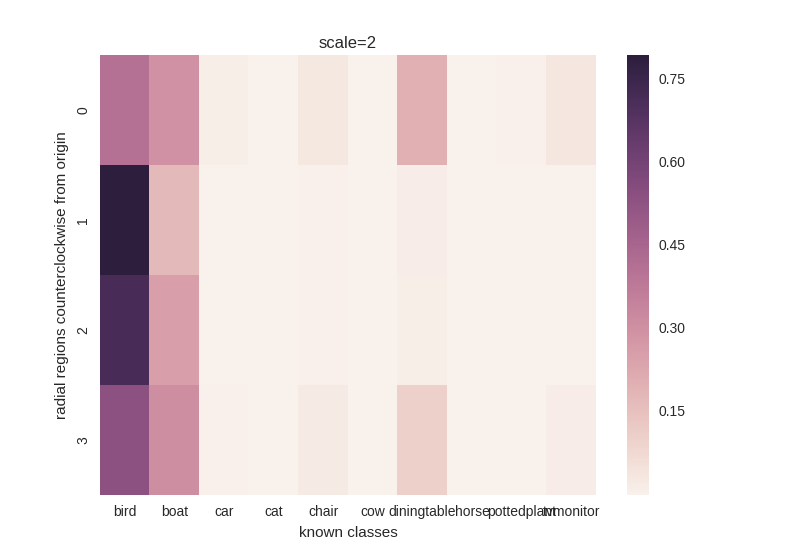

In [2]:
# An example of an Object Graph Descriptor formed according to that definition.
Image("paper/resources/airplane_heat.png")

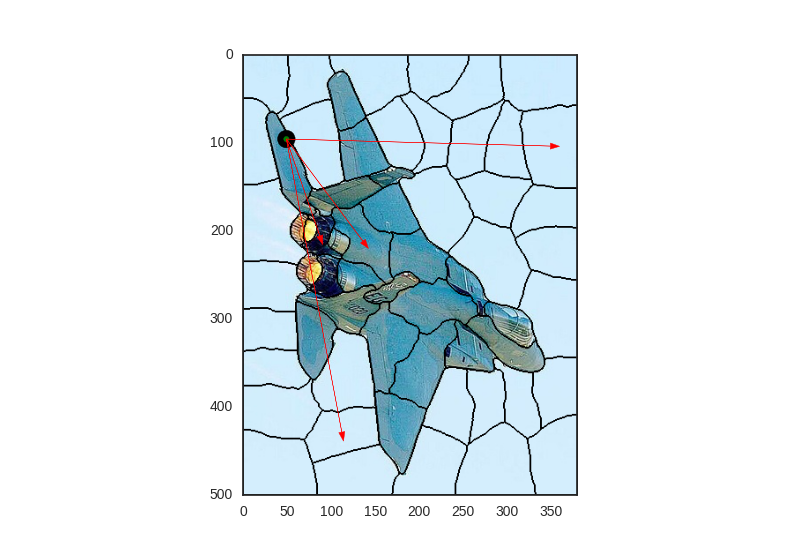

In [14]:
# The image the object graph descriptor above corresponds to.
# The black lines are superpixels (finer grained units of context than segments, which are what is pooled).
# The red lines show the separation found as the result of minimizing segment count entropy plus saliency entropy 
# (a hand-crafted feature designed to demonstrate room for improvement).
Image("paper/resources/airplane.png")

/usr/local/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:257: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


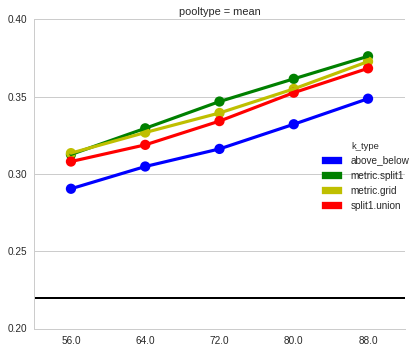

In [203]:
# calculated with run.py:handPurities.
# should maybe add this as seaborn documentation when I get a moment.
from scipy.stats import mode
labels = pickle.load(open(params.root('kernels/above_below_0_1.31_2_4_3_0.45'),'rb'))[1]['gt']
base = mode(labels).count[0]
purityData = pickle.load(open(params.root('results/puritydata_0.0_1.31.pkl'),'rb'))
color_spec = {'above_below' : 'b', 'metric.split1' : 'g', 'metric.grid' : 'y', 'split1.union' : 'r'}
# Instead of 'k', I think I can use a function of 'k' to get the info I want.
legend_data = { k : mpatches.Patch(color=color_spec[k], label=k) for k in color_spec.keys()}
all_data = purityData[(purityData['splitid'] == 0) & (purityData['easiness'] == 1.31)]
context_data = all_data[all_data.k_type.isin(color_spec.keys())]
context_data = context_data[(context_data.num_fields == 200) | (context_data['num_fields'].isnull())]
context_data = context_data.append(all_data[(all_data.k_type == 'split1.union') & (all_data.num_fields == 100)])
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(context_data,col="pooltype", size=5,aspect=0.9,hue="k_type",palette=color_spec, sharey=True)
    g.add_legend(legend_data = legend_data)
    g.map(sns.pointplot, "num_clusters", "purities")
    g.map(plt.axhline,y=(base / len(labels)), c='k')
    #g.add_legend()
    #g.fig.suptitle("Purity of Discovered Classes with 60 Unknown Classes in COCO")
    #g.axes[0][0].add_legend()
    plt.savefig('mainresult.png')

In [12]:
# calculated with run.py:handPurities.
# should maybe add this as seaborn documentation when I get a moment.
from scipy.stats import mode
labels = pickle.load(open(params.root('kernels/above_below_0_1.31_2_4_3_0.45'),'rb'))[1]['gt']
base = mode(labels).count[0]
purityData = pickle.load(open(params.root('results/newpuritydata_0.0_1.31.pkl'),'rb'))
color_spec = {'euclidean.split1' : 'b', 'metric.split1' : 'g', 'metric.grid' : 'y', 'euclidean.grid' : 'r'}
# Instead of 'k', I think I can use a function of 'k' to get the info I want.
legend_data = { k : mpatches.Patch(color=color_spec[k], label=k) for k in color_spec.keys()}
all_data = purityData[(purityData['splitid'] == 0) & (purityData['easiness'] == 1.31)]
print(np.unique(all_data.k_type))
context_data = all_data[all_data.k_type.isin(color_spec.keys())]
context_data = context_data[(context_data.num_fields == 200) | (context_data['num_fields'].isnull())]
context_data = context_data.append(all_data[(all_data.k_type == 'split1.union') & (all_data.num_fields == 100)])
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(context_data,col="pooltype", size=5,aspect=0.9,hue="k_type",palette=color_spec, sharey=True)
    g.add_legend(legend_data = legend_data)
    g.map(sns.pointplot, "num_clusters", "purities")
    g.map(plt.axhline,y=(base / len(labels)), c='k')
    #g.add_legend()
    #g.fig.suptitle("Purity of Discovered Classes with 60 Unknown Classes in COCO")
    #g.axes[0][0].add_legend()
    plt.savefig('mainresult.png')

/usr/local/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:257: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


FileNotFoundError: [Errno 2] No such file or directory: '/data/aseewald/good/results/newpuritydata_0.0_1.31.pkl'

In [195]:
context_data.append?

/usr/local/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:257: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


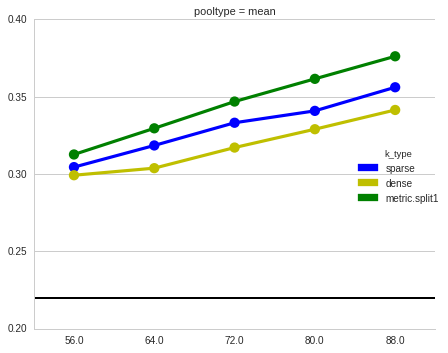

In [133]:
# calculated with run.py:handPurities.
# should maybe add this as seaborn documentation when I get a moment.
from scipy.stats import mode
labels = pickle.load(open(params.root('kernels/above_below_0_1.31_2_4_3_0.45'),'rb'))[1]['gt']
base = mode(labels).count[0]
purityData = pickle.load(open(params.root('results/puritydata_0.0_1.31.pkl'),'rb'))
color_spec = {'sparse' : 'b', 'metric.split1' : 'g', 'dense': 'y'}
legend_data = { k : mpatches.Patch(color=color_spec[k], label=k) for k in color_spec.keys()}
all_data = purityData[(purityData['splitid'] == 0) & (purityData['easiness'] == 1.31)]
context_data = all_data[all_data.k_type.isin(color_spec.keys())]
context_data = context_data[(context_data.num_fields == 200) | (context_data['num_fields'].isnull())]
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(context_data,col="pooltype", size=5,aspect=1.0,hue="k_type",palette=color_spec, sharey=True)
    g.add_legend(legend_data = legend_data)
    g.map(sns.pointplot, "num_clusters", "purities")
    g.map(plt.axhline,y=(base / len(labels)), c='k')
    #g.add_legend()
    #g.fig.suptitle("Purity of Discovered Classes with 60 Unknown Classes in COCO")
    #g.add_legend()
    plt.savefig('sparsedense.png')

In [1]:
from scipy.stats import mode
labels = pickle.load(open(params.root('kernels/above_below_0_1.31_2_4_3_0.45'),'rb'))[1]['gt']
base = mode(labels).count[0]
purityData = pickle.load(open(params.root('results/puritydata_0.0_1.31.pkl'),'rb'))
color_spec = {'above_below' : 'b','metric.split1' : '#ff44aa','euclidean.split1' : 'y'}
legend_data = { str(k) : mpatches.Patch(color=color_spec[k], label=k) for k in color_spec.keys()}
all_data = purityData[(purityData['splitid'] == 0) & (purityData['easiness'] == 1.31)]
context_data = all_data[all_data.k_type.isin(color_spec.keys())]
context_data = context_data[(context_data.num_fields == 100) | (context_data['num_fields'].isnull())]
print(np.unique(all_data['k_type']))
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(context_data,col="pooltype", hue="k_type",size=5,aspect=0.6,palette=color_spec, sharey=True)
    g.add_legend(legend_data = legend_data)
    g.map(sns.pointplot, "num_clusters", "purities")
    g.map(plt.axhline,y=(base / len(labels)), c='k')
    axes = g.axes[0][0]
    axes.set_ylim(0.2,0.4)
    #g.add_legend()
    #g.fig.suptitle("Purity of Discovered Classes with 60 Unknown Classes in COCO")
    #g.add_legend()
    plt.savefig('objclass.png')

NameError: name 'pickle' is not defined

[   3.   15.   30.   60.  100.  150.  200.]


/usr/local/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:257: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


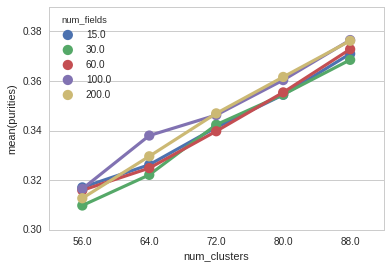

In [130]:
from scipy.stats import mode
labels = pickle.load(open(params.root('kernels/above_below_0_1.31_2_4_3_0.45'),'rb'))[1]['gt']
base = mode(labels).count[0]
purityData = pickle.load(open(params.root('results/puritydata_0.0_1.31.pkl'),'rb'))
color_spec = {200 : 'g', 100 :'b', 60 : 'y',30 : 'r', 15 : 'm'}
legend_data = { str(k) : mpatches.Patch(color=color_spec[k], label=k) for k in color_spec.keys()}
all_data = purityData[(purityData['splitid'] == 0) & (purityData['easiness'] == 1.31)]
context_data = all_data[all_data.k_type.isin(['metric.split1'])]
print(np.unique(context_data['num_fields']))
context_data = context_data[context_data.num_fields.isin([200,100,60,30,15])]
with sns.axes_style('whitegrid'):
    sns.pointplot(data=context_data,x="num_clusters", y="purities",hue='num_fields',aspect=1.4)
    plt.savefig('numfields.png')

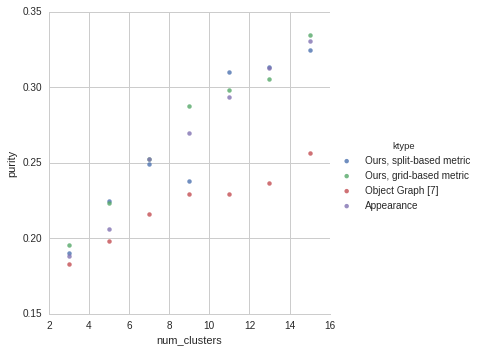

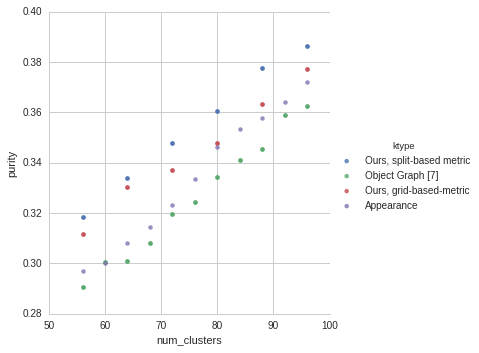

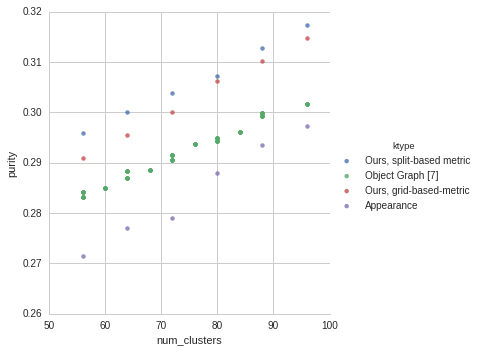

In [110]:
splitid = 0
pooltype = 'mean'

import sqlite3
def comparison_plot(conn,spec,figname,rename):
    arr = []
    for k_type,vals in spec.items():
        num_fields, easiness = vals
        ps = pd.read_sql("SELECT num_clusters, purities FROM purity WHERE splitid = {} AND pooltype = '{}' AND easiness = {} AND k_type = '{}' AND num_fields = {}".format(splitid,pooltype,easiness,k_type,num_fields),conn)
        for p in ps.iterrows():
            p = p[1]
            arr.append([p['num_clusters'], p['purities'],rename[k_type]])
    for p in pd.read_sql("SELECT num_clusters, purities FROM purity  WHERE k_type = 'above_below' AND easiness = {}".format(easiness),conn).iterrows():
        p = p[1]
        arr.append([p['num_clusters'],p['purities'],rename['above_below']])
    for p in pd.read_sql("SELECT num_clusters, purities FROM purity  WHERE k_type = 'cnnapp' AND easiness = {}".format(easiness),conn).iterrows():
        p = p[1]
        arr.append([p['num_clusters'],p['purities'],rename['cnnapp']])
    data = pd.DataFrame(arr,columns=['num_clusters','purity','ktype'])
    with sns.axes_style('whitegrid'):
        plt.figure(figsize=(10,10))
        sns.lmplot(data=data,x="num_clusters",y='purity',hue='ktype',fit_reg=False)
        plt.savefig(figname)
cococonn = sqlite3.connect('/fast-data/aseewald/obnext.db')
pasconn = sqlite3.connect('/fast-data/aseewald/pascal.db')
comparison_plot(pasconn, {'above_below' : (-1,1.31), 'metric.split1' : (200,1.26), 'metric.grid' : (200,1.26)}, "pascal.png", {'above_below' : 'Object Graph [7]', 'metric.split1' : 'Ours, split-based metric', 'metric.grid' : 'Ours, grid-based metric', 'cnnapp' : 'Appearance'})
comparison_plot(cococonn,{'above_below' : (-1,1.31), 'metric.split1' : (100,1.31), 'metric.grid' : (100,1.31)},"main.png",
                {'above_below' : 'Object Graph [7]', 'metric.split1' : 'Ours, split-based metric',
                'metric.grid' :'Ours, grid-based-metric', 'cnnapp' : 'Appearance'})
comparison_plot(cococonn, {'above_below' : (-1,1.21), 'metric.split1' : (30,1.21), 'metric.grid' : (30,1.21)},"larger",{'above_below' : 'Object Graph [7]', 'metric.split1' : 'Ours, split-based metric',
                'metric.grid' :'Ours, grid-based-metric','cnnapp' : 'Appearance'})

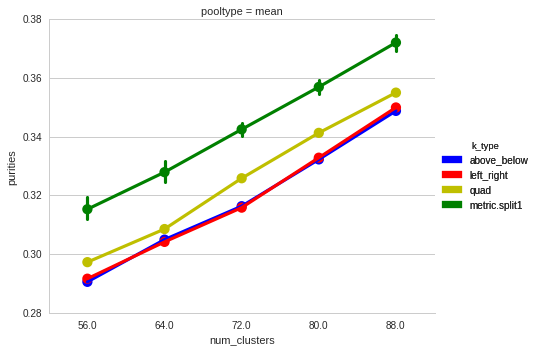

In [124]:
# calculated with run.py:handPurities.
# should maybe add this as seaborn documentation when I get a moment.
purityData = pickle.load(open(params.root('results/puritydata_0.0_1.31.pkl'),'rb'))
color_spec = {'above_below' : 'b', 'quad' : 'y','left_right' : 'r', 'metric.split1': 'g'}
legend_data = { k : mpatches.Patch(color=color_spec[k], label=k) for k in color_spec.keys()}
all_data = purityData[(purityData['splitid'] == 0) & (purityData['easiness'] == 1.31)]
context_data = all_data[all_data.k_type.isin(color_spec.keys())]
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(context_data,col="pooltype", size=5,hue="k_type",palette=color_spec, sharey=True)
    g.add_legend(legend_data = legend_data)
    g.map(sns.pointplot, "num_clusters", "purities")
    #g.add_legend()
    g.add_legend()
    plt.savefig('handcrafted.png')

# Analysis

Evidently, there is little reason to prefer any of these hand-crafted definitions over one another. However, they all perform significantly better than the baseline (indicated by the black line which would be the strategy of simply choosing the most frequent unknown class). Pooling according to an above-vs-below split or a left-vs-right split or quadrants or the optimization problem I posed does not seem to matter very much. Another observation is that the type of pooling, mean or max, does not have much of an effect.

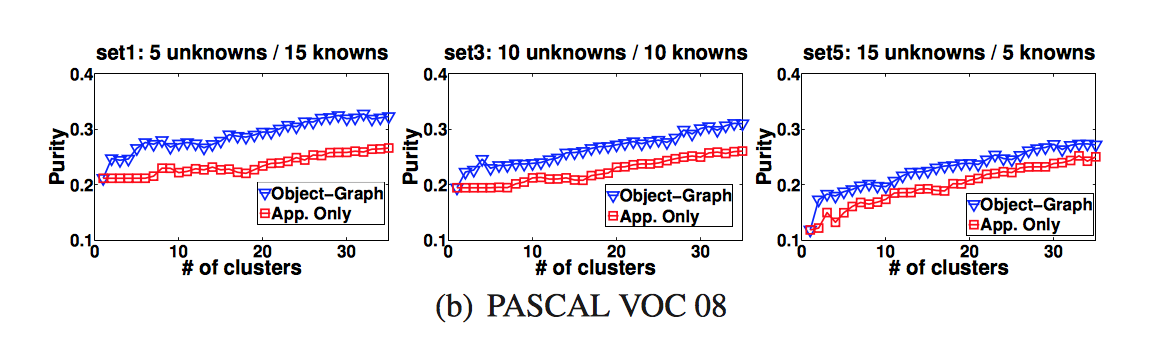

In [120]:
# As a point of comparison, this is the original performance. It is not as good as the results above, despite the
# exact same object graph descriptor definition. This could be due to differences in the datasets or differences
# in the features.
Image('orig_purity.png')

# Effect of Distance Function

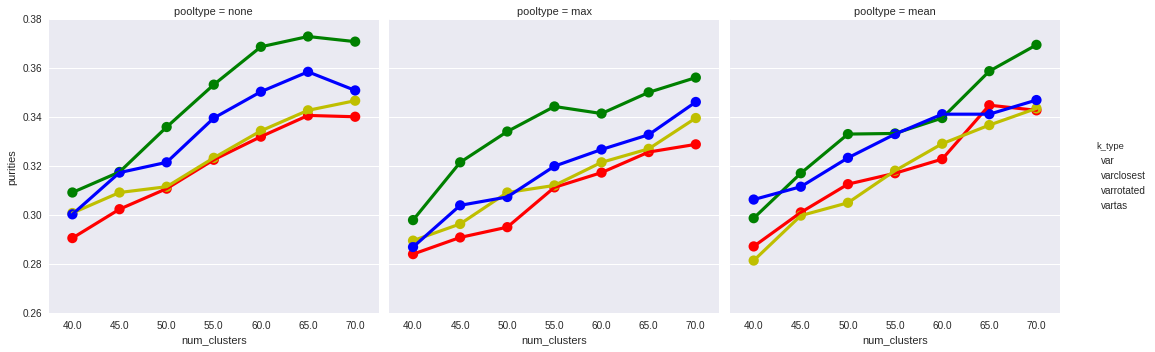

In [121]:
color_spec = {'var' : 'g', 'vartas' : '#ee55aa', 'varrotated' : '#55aaee', 'varclosest' : '#aa55ee'}
context_data = all_data[all_data.k_type.isin(color_spec.keys())]
with sns.axes_style('darkgrid'):
    g = sns.FacetGrid(context_data,col="pooltype", size=5,hue="k_type",palette=color_spec, sharey=True)
    g.map(sns.pointplot, "num_clusters", "purities")
    g.add_legend()
    plt.savefig('purities.png')

Even though the receptive fields differ from object candidate to object candidate, chisquared distances still work better than attempts to define more suitable distance functions

# Comparison of Appearance Features

In [1]:
color_spec = {'texton' : '#007733', 'pyramid' : '#770033', 'abovebelow' : 'b'}
context_data = all_data[all_data.k_type.isin(color_spec.keys())]
with sns.axes_style('darkgrid'):
    g = sns.FacetGrid(context_data,col="pooltype", size=5,hue="k_type",palette=color_spec, sharey=True)
    g.map(sns.pointplot, "num_clusters", "purities")
    g.add_legend()
    plt.savefig('purities.png')

NameError: name 'all_data' is not defined

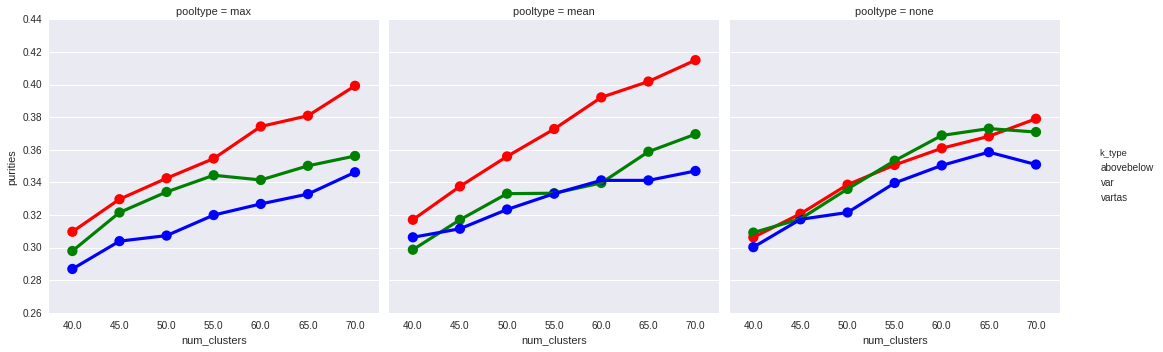

In [98]:
color_spec = {'var' : 'g', 'vartas' : '#ee55aa', 'abovebelow' : 'b'}
context_data = all_data[all_data.k_type.isin(color_spec.keys())]
with sns.axes_style('darkgrid'):
    g = sns.FacetGrid(context_data,col="pooltype", size=5,hue="k_type",palette=color_spec, sharey=True)
    g.map(sns.pointplot, "num_clusters", "purities")
    g.add_legend()
    plt.savefig('purities.png')

# Comparison to Baselines

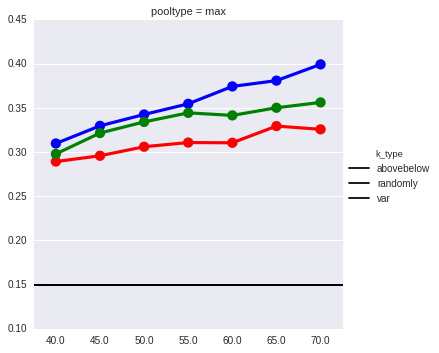

In [124]:
from scipy.stats import mode
color_spec = {'var' : 'g', 'abovebelow' : 'b', 'randomly' : 'r'}
labels = pickle.load(open(params.root('kernels/abovebelow_2_1.3_max_2_4_3_0.45'),'rb'))[1]
base = mode(labels).count[0]
context_data = all_data[all_data.k_type.isin(color_spec.keys())]
context_data = context_data[context_data.pooltype == 'max']
with sns.axes_style('darkgrid'):
    g = sns.FacetGrid(context_data,col="pooltype", size=5,hue="k_type",palette=color_spec, sharey=True)
    g.map(sns.pointplot, "num_clusters", "purities")
    g.map(plt.axhline,y=(base / len(labels)), c='k')
    g.add_legend()
    plt.savefig('purities.png')

Interestingly, randomly assigning superpixels' features into receptive fields (without any spatial pattern) performs more similarly to the real methods than the baseline. 

# Breakdown of var field into components

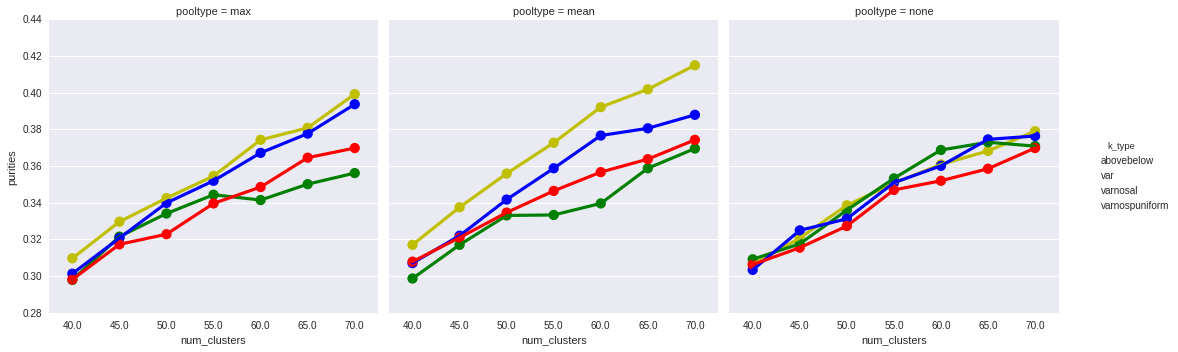

In [95]:
color_spec = {'var' : 'r', 'varnosal' : 'g', 'varnospuniform' : 'r', 'abovebelow' : 'b'}
context_data = all_data[all_data.k_type.isin(color_spec.keys())]
with sns.axes_style('darkgrid'):
    g = sns.FacetGrid(context_data,col="pooltype", size=5,hue="k_type",palette=color_spec, sharey=True)
    g.map(sns.pointplot, "num_clusters", "purities")
    g.add_legend()
    plt.savefig('purities.png')

Turns out that using the saliency information did not help.


# An approach to learning receptive fields: Overcomplete set of rectangular regions.

### Pooling of features (as above) happens within these rectangular regions. 'Overcomplete' means possibly overlapping areas.

### The coordinates of the receptive fields are, unlike the original paper, centered around the object candidate rather than global in the image.

### Learn them with the pretext task of trying to predict labels of known objects.

### I'm using 32,000 possible receptive fields, making for a 32,000 * num_classes dimensional regression problem. This is very high-dimensional, so grafting is used.

In [ ]:
# Starting point for interactive adding of receptive fields
num_added_per_click = 1

fig, ax = plt.subplots(ncols=2,figsize=(15,8))
ax[0].set_xlim(-1,1)
ax[1].set_xlim(-1,1)
# I can put a legend of class colors.
classcolors = { }
split1params = pd.read_sql("SELECT * FROM field_params",sqlite3.connect('/fast-data/aseewald/obnext.db'))
g = sns.FacetGrid(split1params,hue="category")
for i, field in split1params.iterrows():
    classcolor = classcolors[i % num_classes]
    sns.pointplot(x=)
    sns.
    #rect = mpatches.Rectangle((field[0], field[2]), field[1] - field[0], field[3] - field[2],alpha=0.4,color=classcolor)
    ax[0].add_patch(rect)
    display.clear_output(wait=True)
    display.display(fig)
    input("Enter enter for next receptive field")


0.724200394865
category
backpack          0.038291
baseball glove    0.002482
bird              0.565963
cell phone        0.155123
handbag           0.016042
orange            0.139540
surfboard         0.077958
tie               0.004600
Name: scale, dtype: float64
classname
backpack          49
baseball glove     2
bird              63
cell phone        46
handbag           55
orange            62
surfboard         80
tie               21
Name: imgname, dtype: int64
correlation:  0.406188949258


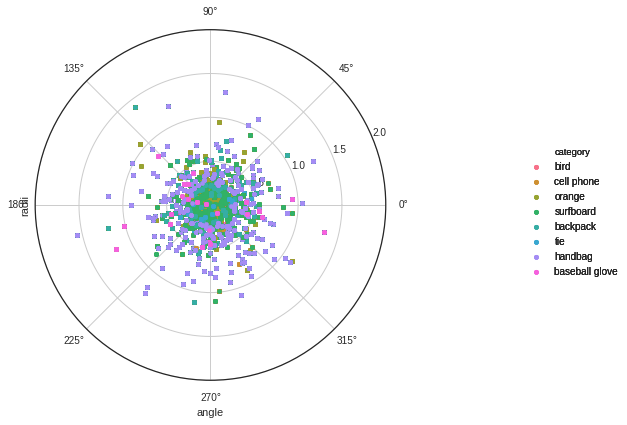

In [217]:
import sqlite3
conn = sqlite3.connect('/fast-data/aseewald/obnext.db')
parm = pd.read_sql("SELECT * FROM field_params",conn)
angles = parm['angle']
r = np.sqrt(parm['offset_x'] ** 2 + parm['offset_y'] ** 2)
parm['radii'] = pd.Series(r / np.max(r),name="offset radius")
parm = parm[parm['radii'] < 1]
parm.reindex(np.random.permutation(parm.index))
print(np.max(parm['radii']))
#ax = plt.subplot(111,polar=True)
cmap = {objclass : random.choice(plt.cm.viridis.colors) for i,objclass in enumerate(np.unique(parm['category']))}
knownclasses = np.unique(parm['category'])
colors = [cmap[objclass] for objclass in parm['category']]
g = sns.FacetGrid(parm,hue='category',subplot_kws={'projection' : 'polar'},despine=False,size=6)
g.map(plt.scatter,'angle','offset_x')
g.add_legend()
plt.savefig('angle_offset_x.png')
g.map(plt.scatter,'angle','offset_y')
g.add_legend()
plt.savefig('angle_offset_y.png')
prop_fields = parm.groupby('category').count()['scale'] / len(parm)
g.map(plt.scatter,'angle','radii')
g.add_legend()
plt.savefig('angle_rad.png')
print(prop_fields)
prop_labels = pd.read_sql("SELECT * FROM ground_truth",conn)
prop_labels = prop_labels[prop_labels['classname'].isin(knownclasses)]
prop_labels = prop_labels.groupby('classname').count()['imgname']
print(prop_labels)
print("correlation: ", prop_fields.corr(prop_labels))

In [ ]:
# Correlation of Receptive Fields over object type.
learned_fields = pickle.load(open(params.root('results/learned_fields.pkl'),'rb'))
for splitid in np.unique(learned_fields['splitid'].values):
    fields = learned_fields[learned_fields.splitid == splitid]
    for nfields in constants.num_fields[]
    split1 = fields[fields.field_type == 'split;1']
    # np.cov - heatmap this.
    split2 = fields[fields.field_type == 'split;2']
    split3 = fields[fields.field_type == 'split;3']
    grid = fields[fields.field_type == 'grid']

In [ ]:
# Plot of class-specific receptive fields, overlayed with 

# Another approach to learning receptive fields: Random 'splits'

### 'Splits' means pooling happens separately above and below.
### Splits are defined using 2 parameters - a point (relative offset from object candidate center) and an angle.
### Angle paramters are chosen with a uniform distribution, and offset parameters are chosen with a gaussian distribution with mean at the center of the object candidate (0,0).

In [ ]:
for j, offset in enumerate(offsets):
    if j not in np.floor(np.array(split_fields) / 8):
        continue
    angle = angles[j]
    arr = mpatches.Arrow(offset[0],offset[1],math.sin(math.radians(angle)),math.cos(math.radians(angle)),width=0.03)
    ax[1].add_patch(arr)
    display.clear_output(wait=True)
    display.display(fig)
    input("Enter enter for next receptive field")

# Easiness - the guiding force of the self-paced learning
## Easiness(s) = Objectness(s) + ContextAwareness(s)

A variety of computer vision papers have considered objectness: an object-class-independent measure of how object-like image data is. Newer work like [5] has been done, but I use the implementation in [4] because their code is publicly available.

$$ ContextAwareness(s) = \sum_s' entropy(s'.object_distribution) / \| s'.center - s.center \| $$

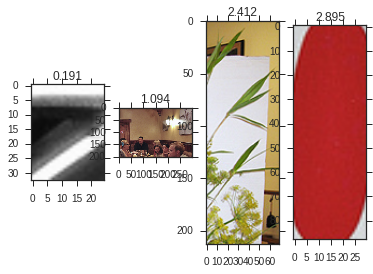

In [133]:
# automatically make ascending_easiness variable.
asc = [pickle.loads(gzip.open(params.root('val_segments/{}_{}.pkl.gz'.format(x[0],x[1]))).read())[x[2]] for x in ascending_easiness]
easinesses = [0.191,1.094,2.412,2.895]

fig, axes = plt.subplots(ncols=4)
for i, seg in enumerate(asc):
    axes[i].imshow(seg.img_patch)
    axes[i].set_title(str(easinesses[i]))

# Recalling the Motivation of the paper : Shouldn't the definition of receptive field be a function of relevant information?

Idea - relevant information, e.g. location of image boundaries, occlusions within images, etc can be encoded in histograms of a class-independent measure of objectness, where bins are angular regions of the image. Clusters of object candidates of 'like context' can be defined as clusters within this feature space of objectness histograms. The receptive field learning process can be conducted separately in the different context clusters.

In [ ]:
# plot of distribution of easiness.
conn = sqlite3.connect(params.root('obnext.db'))
easiness_distr = pd.read_sql("SELECT easiness FROM easiness",conn)['easiness']
sns.distplot(easiness_distr,kde=True)

# now, do a jointplot of easiness and objectness.